# Logistic Regression with Numpy/Numba/JAX

In this notebook I tried to naively optimize a classic **LR**(*MLE*) with *Gradient Descent* testing with Numpy, Numba and JAX. Please be aware that I am not an Applied Mathematician and tried to do things in the simplest of ways I could get from reading the docs.

## Structure

All Logit functions are available in **functions.py**, analysis is done through this notebook.

## About

I am Leonardo Brioschi, a *Ph.D. candidate at Accounting/Finance track*. Please visit **https://leobrioschi.gitlab.io**


## Data wrangling/cleaning

In [15]:
#import libraries

import pandas as pd
import numpy as np
from scipy import linalg
import pickle

#functions
import functions as fc

#data viz
import matplotlib.pyplot as plt
import seaborn as sns

#silence
import warnings
warnings.filterwarnings('ignore')

In [16]:
#Setup variables
filename = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
split = 0.3 #size of test
cv = 0.2 #size of cv, counted over remainder from train

In [17]:
# Data Cleaning

def wrangle(filename):
    df = pd.read_csv(filename)
    df.drop(columns=['customerID'],inplace=True)
    df = df[df['TotalCharges'] != ' ']
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    category = ['gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Churn']
    df[category] = df[category].astype('category')
    return df

In [18]:
#Load Data
df = wrangle(filename)

In [19]:
#Selecting categoricals and handling them
categoricals = df.describe(exclude='number')
cat_binary = categoricals.loc['unique',categoricals.loc['unique',:] == 2].index.to_list()
cat_many = categoricals.loc['unique',categoricals.loc['unique',:] > 2].index.to_list()

In [20]:
for each in cat_binary:
    if each != 'gender':
        df[each].replace(['No', 'Yes'],
                        [0, 1], inplace=True)
        df[each] = pd.to_numeric(df[each])
    else:
        df[each].replace(['Male', 'Female'],
                        [0, 1], inplace=True)
        df[each] = pd.to_numeric(df[each])
    

In [21]:
dummies = list()
for each in cat_many:
    dummies.append(pd.get_dummies(df[each],prefix=each,drop_first=True)) #avoiding multicollinearity
dummies = pd.concat(dummies,axis='columns')

df.drop(columns=cat_many,inplace=True)
df=pd.concat([df,dummies],axis='columns')

In [22]:
df.dropna(inplace=True) #classic

Creating training/cv/test samples. At this time I am not doing any prediction or checking results.

In [23]:
m=len(df)
train=round(m*(1-split))
df_test = df.iloc[train:,:]
cv_index=round(train*(1-cv))
df_cv = df.iloc[cv_index:train,:]
df_train = df.iloc[0:cv_index,:]

In [24]:
y=df_train['Churn'].to_numpy()
y=y[:,np.newaxis]
X=df_train.drop(columns=['Churn']).to_numpy()

## Running LRs

In [25]:
X=np.concatenate([np.ones((X.shape[0],1)),X],axis=1) #add constant
init=np.random.default_rng(42).random((X.shape[1],1))

In [26]:
np_run = %timeit -r 10 -o fc.lr(init,X,y,alpha=0.000001,ite=1000)

11.1 s ± 605 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [27]:
nb_run = %timeit -r 10 -o fc.nblr(init,X,y,alpha=0.000001,ite=1000)

11.7 s ± 512 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [28]:
jax_run = %timeit -r 10 -o fc.jlr(init,X,y,alpha=0.000001,ite=1000)

1.79 s ± 113 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## Results

In [54]:
cost,theta,all_cost = fc.jlr(init,X,y,alpha=0.000001,ite=5000)

In [55]:
cost = cost.to_py()
theta = theta.to_py()
all_costs = list()
for each in all_cost:
    all_costs.append(float(each.to_py()))
del all_cost

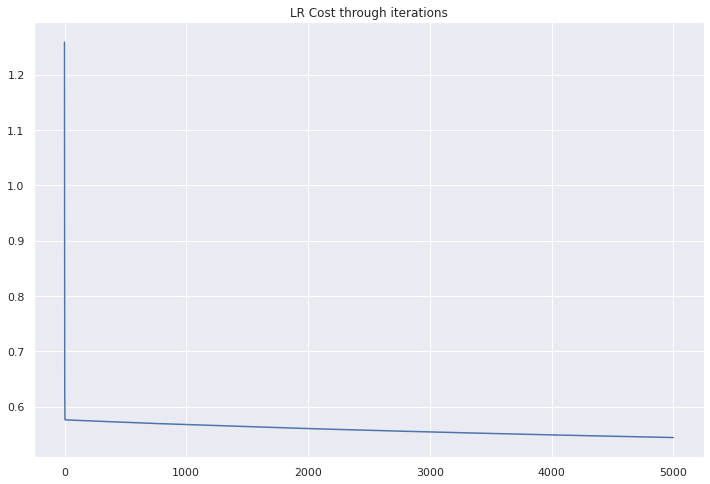

In [64]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12,8))
sns.lineplot(x=range(len(all_costs)),y=all_costs).set(title='LR Cost through iterations');
plt.savefig('web/cost_func.png')

In [66]:
results = pd.DataFrame({'Numpy':np_run.all_runs,'Numba':nb_run.all_runs,'JAX':jax_run.all_runs})

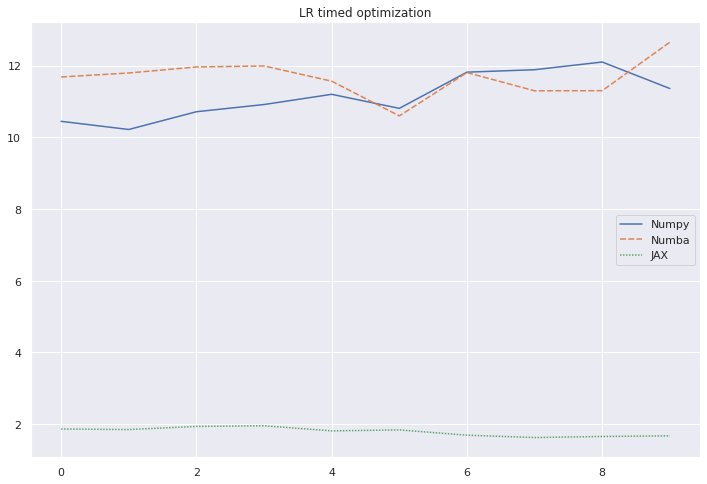

In [71]:
plt.figure(figsize=(12,8))
sns.lineplot(data=results).set(title='LR timed optimization');
plt.savefig('web/results.png')